In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
import healpy as hp
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
import pyshtools
import pdb


optimal_sigmas = {
    1:1,
    2:0.3,
    4:0.175,
    8:0.0525,
    16:0.015,
    32:0.002
}


class MyGraph(Graph):
    
    def __init__(self, W, coords):
        super(MyGraph, self).__init__(W=W, coords=coords)
        

    
    def _init_vtk(self):
        from pyevtk.vtk import VtkTriangle, VtkQuad
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid


    def save_signal(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
        

class FullHEALPix(MyGraph):
    sigmas = optimal_sigmas
    
    def make_coords(self):
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes)  # RING (DEFAULT) ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        if isinstance(std, float) or isinstance(std, int):
            W = np.exp(-distances_squared / std)
        else:
            W = np.exp(-distances_squared / self.sigmas[nside])
        W = W-np.diag(np.diag(W))
        super(FullHEALPix, self).__init__(W=W, coords=coords)
        self._init_vtk()
    

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)  
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

### First test
Here we test manually and visually that everything we do is correct. We do the following tests:
* We show a signal on the sphere 
* We rotate it to check there's no aberration in performing this rotation
* We filter it by mutiplying it by L 

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


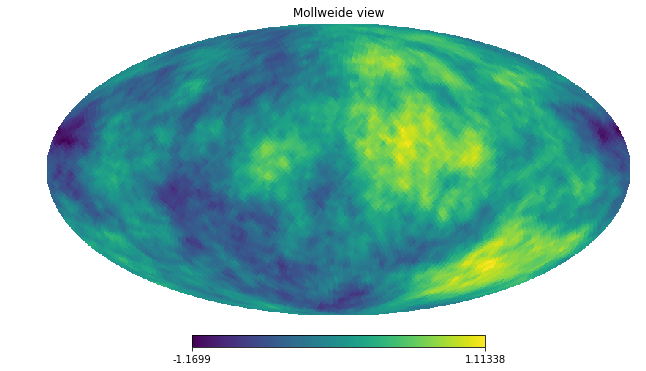

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


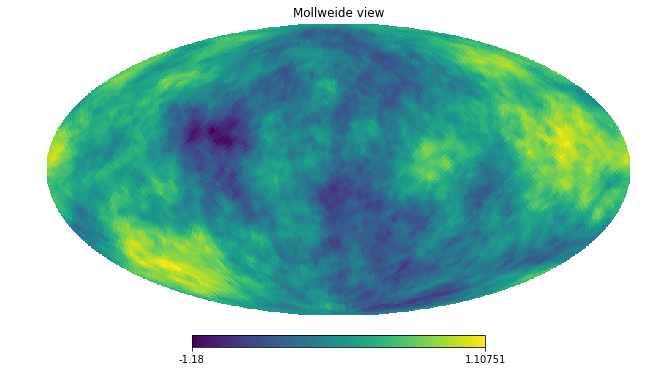

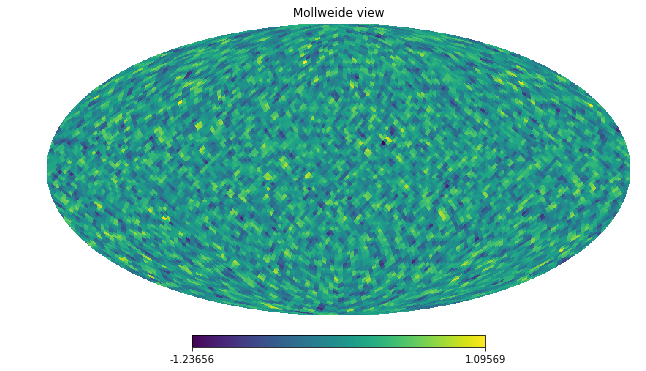

In [21]:
nside=32
lmax = 3*nside-1
degrees = np.arange(lmax+1, dtype=float)
degrees[0] = np.inf
power = degrees**(-3) ## just for plotting

hmap = hp.sphtfunc.synfast(power, nside=nside)
hp.visufunc.mollview(hmap, nest=False)
plt.show()

rot = hp.rotator.Rotator(rot=[100,0, 0])
R_hmap = rot.rotate_map_alms(hmap)
hp.visufunc.mollview(R_hmap)

sphere = FullHEALPix(nside)
F_hmap = sphere.L@hmap
hp.visufunc.mollview(F_hmap)

# Thesis graphs
Here we write the code necessary to reproduce the graphs with the equivariance error by degree, where the correct (spectral) way of rotating the signals is used instead

In [20]:
def _equivariance_error(hmap, max_iter, _filter, lmax, nside):
    """Calculates the equivariance error on one signal only
    as average of max_iter random rotations"""

    initial_norm = np.linalg.norm(hmap)
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    norm = np.zeros(max_iter)
    
    for i, [alpha, beta, gamma] in enumerate(angles):
      
        rot = hp.rotator.Rotator(rot=[alpha, beta, gamma])
        R_hmap = rot.rotate_map_alms(hmap)
        FR_hmap = _filter(R_hmap)
        # ------ first filter, then rotate ------
        F_hmap = _filter(hmap)
        RF_hmap = rot.rotate_map_alms(F_hmap)
        
        norm[i] = np.linalg.norm(RF_hmap-FR_hmap)
    return np.mean(norm)/initial_norm


def equivariance_error(max_iter, _filter, lmax, nside, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    degrees = np.arange(lmax+1, dtype=float)
    
    degrees[0] = np.inf
    
    power = degrees**(-3) ## just for plotting
    if degree is not None:
        assert degree < lmax+1
        power = np.zeros(lmax+1)
        power[degree] = 1
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        hmap = hp.sphtfunc.synfast(power, nside=nside)
        norm[i] = _equivariance_error(hmap, N, _filter, lmax, nside)
    return np.mean(norm)


In [7]:
nside = 32
lmax = 2*nside-1

sphere = FullHEALPix(nside)
HKGL_filter = sphere.L

def diffuse_HKGL(x):
    return HKGL_filter@x

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


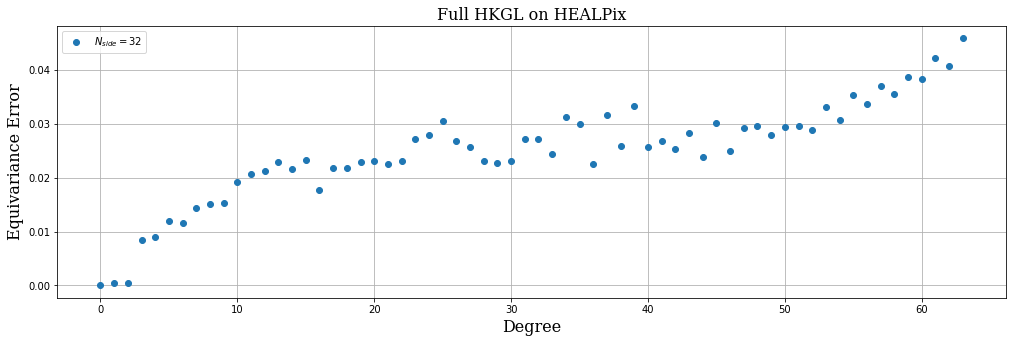

In [8]:
equiv_error = np.zeros(lmax+1)
for degree in range(lmax+1):
    equiv_error[degree] = equivariance_error(5, diffuse_HKGL, lmax,nside, plot=False, degree=degree)
plt.plot(equiv_error, 'o', label=rf'$N_{{side}}={nside}$')
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Full HKGL on HEALPix', fontdict=font)

plt.grid()
plt.legend()
plt.savefig('Full HKGL on HEALPix') 

# Grid search on kernel width

In [15]:
def _equivariance_error(hmap, max_iter, _filter, nside):
    """Calculates the equivariance error on one signal only
    as average of max_iter random rotations"""

    initial_norm = np.linalg.norm(hmap)
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    norm = np.zeros(max_iter)
    
    for i, [alpha, beta, gamma] in enumerate(angles):
      
        rot = hp.rotator.Rotator(rot=[alpha, beta, gamma])
        R_hmap = rot.rotate_map_alms(hmap)
        FR_hmap = _filter(R_hmap)
        # ------ first filter, then rotate ------
        F_hmap = _filter(hmap)
        RF_hmap = rot.rotate_map_alms(F_hmap)
        
        norm[i] = np.linalg.norm(RF_hmap-FR_hmap)
    return np.mean(norm)/initial_norm


def equivariance_error(hmap, max_iter, _filter, nside):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        norm[i] = _equivariance_error(hmap, N, _filter, nside)
    return np.mean(norm)


### Once fixed a hmap, find the best kernel width

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

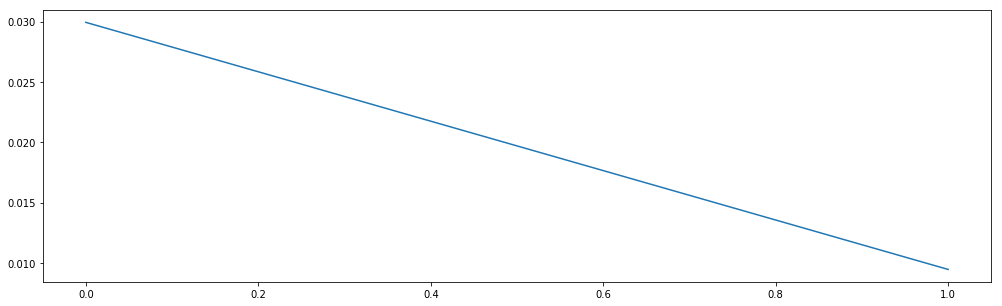

In [19]:
from deepsphere.utils import healpix_graph

# parameters
error = []
nside = 1024
 
# loading hmaps
"""lmax = 3*nside-1
degrees = np.arange(lmax+1, dtype=float)
degrees[0] = np.inf
power = degrees**(-3)
hmap = hp.sphtfunc.synfast(power, nside=nside)"""

hmap = np.load('cosmo/kappa_omega_,_0p26_s_10.npy')

# std deviations to try
stds = [0.1, 0.001]

for std in stds:
    sphere = healpix_graph(nside=nside, nest=True, std=std)
    # WARNING: healpix graph is in NEST ordering
    HKGL_filter = sphere.L

    def diffuse_HKGL(x):
        """x is in RING order, must return result in RING order"""
        x_nest = hp.pixelfunc.reorder(x, r2n=True) 
        F_x_nest = HKGL_filter@x_nest
        return hp.pixelfunc.reorder(F_x_nest, n2r=True) 
    
    error.append(equivariance_error(hmap, 5, diffuse_HKGL, nside))
    del(sphere)

plt.plot(error)
print("The optimum value is std={}".fomat(stds[np.argmin(error)]))